In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For NN models
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

In [2]:
# Load training data
df = pd.read_csv('MPC_datafortraining.csv')
# Create new feature: setpoint error
df['err'] = df['Tsp1'] - df['T1']

In [6]:
# Features: given Tsp1 and err predict Q1
X = df[['Tsp1','err']].values
y = df[['Q1']].values

In [7]:
# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)
s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

In [10]:
# Hyperparameters for model
# The parameters are the same for both networks. To do: optimise parameters.
window = 15
batch_size = 100
drop = 0.1
units = 100

In [11]:
# Each input uses last 'window' number of Tsp and err to predict the next Q1
X_wind = []
y_wind = []
for i in range(window,len(df)):
    X_wind.append(Xs[i-window:i])
    y_wind.append(ys[i])

In [12]:
# Reshape data to proper input for the networks
X_wind, y_wind = np.array(X_wind), np.array(y_wind)

In [13]:
# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_wind,y_wind,test_size=0.2,shuffle=False)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=25)

In [16]:
# LSTM model
model1 = Sequential()

# 2 LSTM layers and 1 dense for output (Q1). Input shape is the size of the input array (window) and the number of features
# (Tsp1 and error)

# Input layer
model1.add(LSTM(units=units, return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
model1.add(Dropout(rate=drop))

# Hidden layer
model1.add(LSTM(units=units))
model1.add(Dropout(rate=drop))

# Output layer
model1.add(Dense(1,activation='relu'))

In [17]:
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 100)           41200     
                                                                 
 dropout_2 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Train the model
result1 = model1.fit(Xtrain, ytrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [early_stop,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 169: early stopping


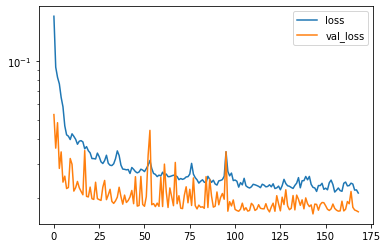

In [19]:
# Training visualization
epochs1 = early_stop.stopped_epoch
plt.semilogy(result1.history['loss'],label='loss')
plt.semilogy(result1.history['val_loss'],label='val_loss')
plt.legend()

In [20]:
# Save model
model1.save('lstm_dense_relu_mpc.h5')

In [21]:
# Save model parameters
model1_params = dict()
model1_params['Xscale'] = s_x
model1_params['yscale'] = s_y
model1_params['window'] = window

pickle.dump(model1_params, open('model_params_dense_relu_lstm.pkl', 'wb'))

In [56]:
# RNN model
model2 = Sequential()

# 2 RNN layers and 1 dense for output (Q1). Input shape is the size of the input array (window) and the number of features
# (Tsp1 and error)

# Input layer
model2.add(SimpleRNN(units=units, return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
model2.add(Dropout(rate=drop))

# Hidden layer
model2.add(SimpleRNN(units=units))
model2.add(Dropout(rate=drop))

# Output layer
model2.add(Dense(1,activation='relu'))

In [57]:
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 15, 100)           10300     
                                                                 
 dropout_10 (Dropout)        (None, 15, 100)           0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 30,501
Trainable params: 30,501
Non-trainable params: 0
_________________________________________________________________


In [58]:
result = model2.fit(Xtrain, ytrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [early_stop,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 48: early stopping


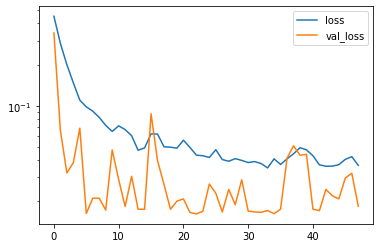

In [59]:
epochs2 = early_stop.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

In [60]:
model2.save('rnn_dense_relu_mpc.h5')

In [61]:
# Save model parameters
model2_params = dict()
model2_params['Xscale'] = s_x
model2_params['yscale'] = s_y
model2_params['window'] = window

pickle.dump(model2_params, open('model_params_dense_relu_rnn.pkl', 'wb'))

In [62]:
# Predict using LSTM
yp_lstm = model1.predict(Xtest)

In [63]:
# Predict using RNN
yp_rnn = model2.predict(Xtest)

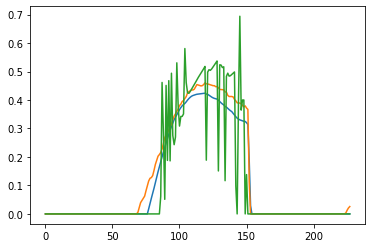

In [64]:
# Raw output comparison
plt.plot(yp_lstm)
plt.plot(yp_rnn)
plt.plot(ytest)

In [65]:
# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
y_lstm = s_y.inverse_transform(yp_lstm)
y_rnn = s_y.inverse_transform(yp_rnn)

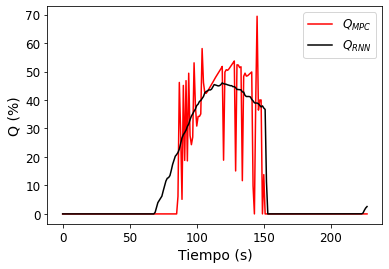

In [73]:
# Plot MPC response vs RNN response
plt.figure(figsize=(6,4))
plt.plot(ytest_us,'r',label='$Q_{MPC}$')
plt.plot(y_rnn,'k',label='$Q_{RNN}$')
plt.legend(fontsize=12,loc='upper right')
plt.xlabel('Tiempo (s)',size=14)
plt.ylabel('Q (%)',size=14)
plt.xticks(size=12)
plt.yticks(size=12);

In [ ]:
# Plot MPC response vs LSTM response
plt.figure(figsize=(6,4))
plt.plot(ytest_us,'r',label='$Q_{MPC}$')
plt.plot(y_lstm,'k',label='$Q_{LSTM}$')
plt.legend(fontsize=12,loc='upper right')
plt.xlabel('Tiempo (s)',size=14)
plt.ylabel('Q (%)',size=14)
plt.xticks(size=12)
plt.yticks(size=12);